In [3]:
import pandas as pd
import sklearn 
import keras
import numpy as np
import xlrd
import collections
import matplotlib.pyplot as plt
import nltk
from wordcloud import WordCloud,ImageColorGenerator
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score

In [4]:
Train=pd.read_csv('D:/Study/DMII/Project/data/drugLib_raw/drugLibTrain_raw.tsv',sep='\t')
Test=pd.read_csv('D:/Study/DMII/Project/data/drugLib_raw/drugLibTest_raw.tsv',sep='\t')


In [ ]:
#print(drug_data)
Train.head()

In [5]:
#Remove columns with null value
Train=Train.fillna(".")

#Convert rating as int , reviews as str
Train.commentsReview=Train.commentsReview.astype(str)
Train.benefitsReview=Train.benefitsReview.astype(str)
Train.sideEffectsReview=Train.sideEffectsReview.astype(str)

Train.rating=Train.rating.astype(int)

#Add new columns for different sizes of reviews
Train['Benefits&Side']=Train['benefitsReview']+" "+Train['sideEffectsReview']
Train['Benefits&Comments']=Train['benefitsReview']+" "+Train['commentsReview']
Train['Side&Comments']=Train['sideEffectsReview']+" "+Train['commentsReview']
Train['All_Comments']=Train['benefitsReview']+" "+Train['sideEffectsReview']+" "+Train['commentsReview']

In [6]:
#Drop useless columns
columns=['Unnamed: 0','urlDrugName','effectiveness','sideEffects','condition']
Train=Train.drop(columns,1)
Train.head()

,rating,benefitsReview,sideEffectsReview,commentsReview,Benefits&Side,Benefits&Comments,Side&Comments,All_Comments
0,4,slowed the progression of left ventricular dys...,"cough, hypotension , proteinuria, impotence , ...","monitor blood pressure , weight and asses for ...",slowed the progression of left ventricular dys...,slowed the progression of left ventricular dys...,"cough, hypotension , proteinuria, impotence , ...",slowed the progression of left ventricular dys...
1,1,Although this type of birth control has more c...,"Heavy Cycle, Cramps, Hot Flashes, Fatigue, Lon...","I Hate This Birth Control, I Would Not Suggest...",Although this type of birth control has more c...,Although this type of birth control has more c...,"Heavy Cycle, Cramps, Hot Flashes, Fatigue, Lon...",Although this type of birth control has more c...
2,10,I was used to having cramps so badly that they...,Heavier bleeding and clotting than normal.,I took 2 pills at the onset of my menstrual cr...,I was used to having cramps so badly that they...,I was used to having cramps so badly that they...,Heavier bleeding and clotting than normal. I t...,I was used to having cramps so badly that they...
3,3,The acid reflux went away for a few months aft...,"Constipation, dry mouth and some mild dizzines...",I was given Prilosec prescription at a dose of...,The acid reflux went away for a few months aft...,The acid reflux went away for a few months aft...,"Constipation, dry mouth and some mild dizzines...",The acid reflux went away for a few months aft...
4,2,I think that the Lyrica was starting to help w...,I felt extremely drugged and dopey. Could not...,See above,I think that the Lyrica was starting to help w...,I think that the Lyrica was starting to help w...,I felt extremely drugged and dopey. Could not...,I think that the Lyrica was starting to help w...


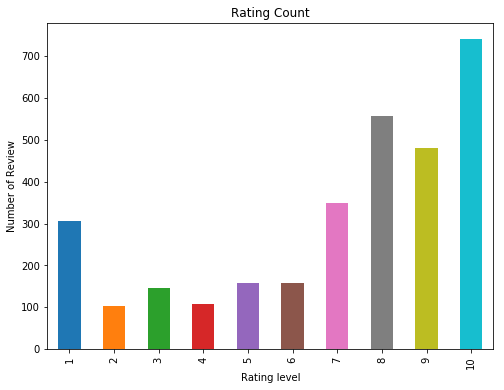

In [7]:
#Count different ratings
fig = plt.figure(figsize=(8,6))
Train.groupby('rating').commentsReview.count().plot.bar(ylim=0)
plt.xlabel('Rating level')
plt.ylabel('Number of Review')
plt.title("Rating Count")
plt.show()

In [8]:
#Combine the ratings for sentiment analysis(3 levels:'positive','negative','neutral')
conditions = [
    (Train['rating']<=4),
    (Train['rating']<8) & (Train['rating']>4),
    (Train['rating']<=10)& (Train['rating']>7)]
choices = ['negative','neutral','positive']
Train['label'] = np.select(conditions, choices, default='black')

#build test set label
conditions = [
    (Test['rating']<=4),
    (Test['rating']<8) & (Test['rating']>4),
    (Test['rating']<=10)& (Test['rating']>7)]
choices = ['negative','neutral','positive']
Test['label'] = np.select(conditions, choices, default='black')

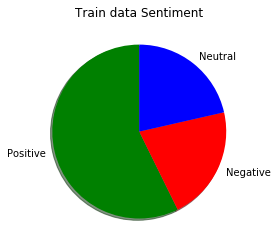

1780


In [19]:
#Pie Chart for Sentiment of Train data
from collections import Counter
sent=Train['label']
counter = Counter(sent)
positive = counter['positive']
negative = counter['negative']
neutral = counter['neutral']
labels = 'Positive', 'Negative', 'Neutral'
sizes = [positive, negative,neutral]
colors = ['green', 'red','blue']
plt.pie(sizes, labels = labels, colors = colors, shadow = True, startangle = 90)
plt.title("Train data Sentiment")
plt.show()
print(positive)

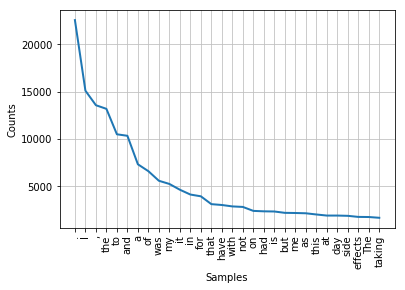

,Word,Frequency
0,.,22569
1,I,15098
2,",",13559
3,the,13175
4,to,10481
5,and,10322
6,a,7305
7,of,6574
8,was,5560
9,my,5224


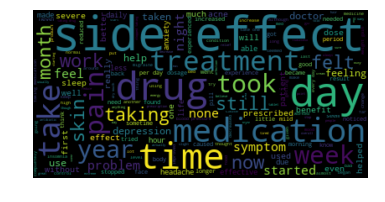

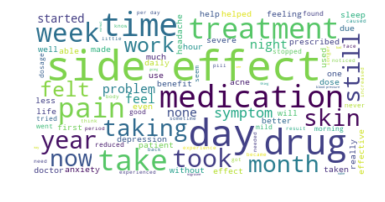

In [9]:
#Count frequency for 'All comments'
from sklearn.feature_extraction.text import CountVectorizer
from nltk.tokenize import RegexpTokenizer

#Build frequency distance matrix
txt = Train.All_Comments.str.replace(r'\|', ' ').str.cat(sep=' ')
words = nltk.tokenize.word_tokenize(txt)
word_dist = nltk.FreqDist(words)

#Words with higher frequency
word_dist.plot(30,cumulative=False)
plt.show()

#The top 100 words
rslt = pd.DataFrame(word_dist.most_common(100), columns=['Word', 'Frequency'])
display(rslt)

wordcloud = WordCloud().generate(txt)
# Display the generated image:
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

wordcloud1 = WordCloud(max_font_size=50, max_words=100, background_color="white").generate(txt)
plt.figure()
plt.imshow(wordcloud1, interpolation="bilinear")
plt.axis("off")
plt.show()

In [10]:
#Build corpus
#tokenizer to remove unwanted elements from out data like symbols and numbers
token = RegexpTokenizer(r'[a-zA-Z0-9]+')
#stop words from NLTK
auto_remove = nltk.corpus.stopwords.words('english')
#Transform top 100 words as list
stopwords=rslt['Word'].values.tolist()

#Combine auto and additional to the final stop word list
for w in auto_remove:
    if w not in stopwords:
        stopwords.append(w)


print(stopwords)
        





['.', 'I', ',', 'the', 'to', 'and', 'a', 'of', 'was', 'my', 'it', 'in', 'for', 'that', 'have', 'with', 'not', 'on', 'had', 'is', 'but', 'me', 'as', 'this', 'at', 'day', 'side', 'effects', 'The', 'taking', 'take', 'after', 'did', ')', '(', "n't", 'drug', 'or', 'pain', 'be', 'i', 'no', 'so', 'very', 'It', 'more', 'were', 'medication', 'would', 'from', 'time', 'about', 'up', 'when', 'which', 'one', 'am', 'days', 'treatment', 'do', 'also', 'skin', 'been', 'an', 'all', 'any', 'if', 'first', 'only', 'took', 'has', 'years', 'My', '!', 'get', 'sleep', 'before', 'feel', 'you', 'months', 'started', 'like', 'are', 'night', 'then', 'could', '2', 'weeks', 'by', 'dose', 'felt', 'some', 'out', 'doctor', 'mg', 'because', 'symptoms', 'much', 'back', 'other', 'myself', 'we', 'our', 'ours', 'ourselves', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', "it's", 'its', 'itself', 'they', 'them', 'their',

In [11]:
#Build vectorizer on count vectors
cv = CountVectorizer(lowercase=True,stop_words=stopwords,ngram_range = (1,1),tokenizer = token.tokenize)
#cv transform for commentsReview
text_counts= cv.fit_transform(Train['commentsReview'])

#Build vectorizer on Word Level TF IDF Vectors
from sklearn.feature_extraction.text import TfidfVectorizer
tf=TfidfVectorizer()
text_tf= tf.fit_transform(Train['commentsReview'])

d:\installation\python36\lib\site-packages\sklearn\feature_extraction\text.py:300: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['n'] not in stop_words.
  'stop_words.' % sorted(inconsistent))


In [12]:
entries=[]
df=pd.DataFrame(columns=['model_name', 'Vectors', 'accuracy'])

from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

#Functions for using different classifying models
def train_model(classifier, feature_vector_train, label, feature_vector_valid,valid_y, is_neural_net=False):
    # fit the training dataset on the classifier
    classifier.fit(feature_vector_train, label)
    
    # predict the labels on validation dataset
    predictions = classifier.predict(feature_vector_valid)
    
    if is_neural_net:
        predictions = predictions.argmax(axis=-1)
    
    print(confusion_matrix(valid_y, predictions))
    print(classification_report(valid_y, predictions)) 
    
    #return metrics.accuracy_score(predictions, valid_y)
    return accuracy_score(valid_y, predictions)

In [13]:
#split train and test set from train dataset
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(
    text_counts, Train['label'], test_size=0.3, random_state=1)

X_train_tfidf, X_test_tfidf, y_train_tfidf, y_test_tfidf = train_test_split(
    text_tf, Train['label'], test_size=0.3, random_state=123)

In [16]:
from sklearn.naive_bayes import MultinomialNB

# Naive Bayes on Count Vectors
accuracy = train_model(MultinomialNB(), X_train, y_train, X_test,y_test)

#Entry accuracy to a list
entries.clear()
entries.append((MultinomialNB().__class__.__name__, "Count Vectors", accuracy))

# Naive Bayes on Word Level TF IDF Vectors
accuracy = train_model(MultinomialNB(), X_train_tfidf, y_train_tfidf, X_test_tfidf,y_test_tfidf)

entries.append((MultinomialNB().__class__.__name__, "Word Level TF IDF Vectors", accuracy))

#transform list to dataframe
df1=pd.DataFrame(entries, columns=['model_name', 'Vectors', 'accuracy'])
display(df1)

[[ 41  22 149]
 [ 20  27 146]
 [ 20  41 467]]
              precision    recall  f1-score   support

    negative       0.51      0.19      0.28       212
     neutral       0.30      0.14      0.19       193
    positive       0.61      0.88      0.72       528

   micro avg       0.57      0.57      0.57       933
   macro avg       0.47      0.41      0.40       933
weighted avg       0.52      0.57      0.51       933

[[  0   0 210]
 [  0   0 180]
 [  0   0 543]]
              precision    recall  f1-score   support

    negative       0.00      0.00      0.00       210
     neutral       0.00      0.00      0.00       180
    positive       0.58      1.00      0.74       543

   micro avg       0.58      0.58      0.58       933
   macro avg       0.19      0.33      0.25       933
weighted avg       0.34      0.58      0.43       933



d:\installation\python36\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


,model_name,Vectors,accuracy
0,MultinomialNB,Count Vectors,0.573419
1,MultinomialNB,Word Level TF IDF Vectors,0.581994


In [27]:
from sklearn.linear_model import LogisticRegression
# Linear Classifier on Count Vectors
accuracy = train_model(LogisticRegression(), X_train, y_train, X_test,y_test)

#Entry accuracy to a list
entries.clear()
entries.append((LogisticRegression().__class__.__name__, "Count Vectors", accuracy))

# Linear Classifier on Word Level TF IDF Vectors
accuracy = train_model(LogisticRegression(), X_train_tfidf, y_train_tfidf, X_test_tfidf,y_test_tfidf)

entries.append((LogisticRegression().__class__.__name__, "Word Level TF IDF Vectors", accuracy))

#transform list to dataframe
df2=pd.DataFrame(entries, columns=['model_name', 'Vectors', 'accuracy'])
display(df2)

[[ 54  24 134]
 [ 26  34 133]
 [ 41  57 430]]
              precision    recall  f1-score   support

    negative       0.45      0.25      0.32       212
     neutral       0.30      0.18      0.22       193
    positive       0.62      0.81      0.70       528

   micro avg       0.56      0.56      0.56       933
   macro avg       0.45      0.42      0.42       933
weighted avg       0.51      0.56      0.52       933

[[ 29   2 179]
 [  8   5 167]
 [ 10  11 522]]
              precision    recall  f1-score   support

    negative       0.62      0.14      0.23       210
     neutral       0.28      0.03      0.05       180
    positive       0.60      0.96      0.74       543

   micro avg       0.60      0.60      0.60       933
   macro avg       0.50      0.38      0.34       933
weighted avg       0.54      0.60      0.49       933



,model_name,Vectors,accuracy
0,LogisticRegression,Count Vectors,0.555198
1,LogisticRegression,Word Level TF IDF Vectors,0.595927


In [28]:
from sklearn.svm import LinearSVC
# Linear SVC Classifier on Count Vectors
accuracy = train_model(LinearSVC(), X_train, y_train, X_test,y_test)

#Entry accuracy to a list
entries.clear()
entries.append((LinearSVC().__class__.__name__, "Count Vectors", accuracy))

# Linear-SVC Classifier on Word Level TF IDF Vectors
accuracy = train_model(LinearSVC(), X_train_tfidf, y_train_tfidf, X_test_tfidf,y_test_tfidf)

entries.append((LinearSVC().__class__.__name__, "Word Level TF IDF Vectors", accuracy))

#transform list to dataframe
df3=pd.DataFrame(entries, columns=['model_name', 'Vectors', 'accuracy'])
display(df3)

[[ 59  41 112]
 [ 29  52 112]
 [ 67  89 372]]
              precision    recall  f1-score   support

    negative       0.38      0.28      0.32       212
     neutral       0.29      0.27      0.28       193
    positive       0.62      0.70      0.66       528

   micro avg       0.52      0.52      0.52       933
   macro avg       0.43      0.42      0.42       933
weighted avg       0.50      0.52      0.51       933

[[ 71  28 111]
 [ 19  25 136]
 [ 40  56 447]]
              precision    recall  f1-score   support

    negative       0.55      0.34      0.42       210
     neutral       0.23      0.14      0.17       180
    positive       0.64      0.82      0.72       543

   micro avg       0.58      0.58      0.58       933
   macro avg       0.47      0.43      0.44       933
weighted avg       0.54      0.58      0.55       933



,model_name,Vectors,accuracy
0,LinearSVC,Count Vectors,0.517685
1,LinearSVC,Word Level TF IDF Vectors,0.581994


In [25]:
df=df.iloc[0:0]
df=df.append(df1.iloc[1],ignore_index=True)
df=df.append(df2.iloc[1],ignore_index=True)
df=df.append(df3.iloc[1],ignore_index=True)
print(df)
df.sort_values(by='accuracy')

           model_name                    Vectors  accuracy
0       MultinomialNB  Word Level TF IDF Vectors  0.581994
1  LogisticRegression  Word Level TF IDF Vectors  0.595927
2           LinearSVC  Word Level TF IDF Vectors  0.581994


,model_name,Vectors,accuracy
0,MultinomialNB,Word Level TF IDF Vectors,0.581994
2,LinearSVC,Word Level TF IDF Vectors,0.581994
1,LogisticRegression,Word Level TF IDF Vectors,0.595927


In [26]:
#Find the classifier with highest accuracy
df.ix[df['accuracy'].idxmax()]


d:\installation\python36\lib\site-packages\ipykernel_launcher.py:2: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated
  


model_name           LogisticRegression
Vectors       Word Level TF IDF Vectors
accuracy                       0.595927
Name: 3, dtype: object

In [37]:
#Use the best classifier to test which types of reivew is the best to train model


#Benefits Review
#Build vectorizer on Word Level TF IDF Vectors
text_tf1= tf.fit_transform(Train['benefitsReview'])

X_train_tfidf, X_test_tfidf, y_train_tfidf, y_test_tfidf = train_test_split(
    text_tf1, Train['label'], test_size=0.3, random_state=123)
# Linear Classifier on Word Level TF IDF Vectors
accuracy = train_model(LogisticRegression(), X_train_tfidf, y_train_tfidf, X_test_tfidf,y_test_tfidf)

entries.clear()
entries.append(("benefitsReview",LogisticRegression().__class__.__name__, "Word Level TF IDF Vectors", accuracy))
#transform list to dataframe
temp0=pd.DataFrame(entries, columns=['ColumnName','model_name', 'Vectors', 'accuracy'])
display(temp0)

##Apply train model in test dataset
text_tf_test=tf.transform(Test['benefitsReview'])
accuracy1 = train_model(LogisticRegression(), text_tf1,Train['label'], text_tf_test,Test['label'])
print(accuracy1)

[[ 71   6 133]
 [ 10   3 167]
 [  6   9 528]]
              precision    recall  f1-score   support

    negative       0.82      0.34      0.48       210
     neutral       0.17      0.02      0.03       180
    positive       0.64      0.97      0.77       543

   micro avg       0.65      0.65      0.65       933
   macro avg       0.54      0.44      0.43       933
weighted avg       0.59      0.65      0.56       933



,ColumnName,model_name,Vectors,accuracy
0,benefitsReview,LogisticRegression,Word Level TF IDF Vectors,0.64523


[[ 88   8 145]
 [ 22  12 212]
 [ 13   7 529]]
              precision    recall  f1-score   support

    negative       0.72      0.37      0.48       241
     neutral       0.44      0.05      0.09       246
    positive       0.60      0.96      0.74       549

   micro avg       0.61      0.61      0.61      1036
   macro avg       0.59      0.46      0.44      1036
weighted avg       0.59      0.61      0.52      1036

0.6071428571428571


In [29]:
#sideEffectsReview
#Build vectorizer on Word Level TF IDF Vectors
text_tf2= tf.fit_transform(Train['sideEffectsReview'])

X_train_tfidf, X_test_tfidf, y_train_tfidf, y_test_tfidf = train_test_split(
    text_tf2, Train['label'], test_size=0.3, random_state=123)
# Linear Classifier on Word Level TF IDF Vectors
accuracy = train_model(LogisticRegression(), X_train_tfidf, y_train_tfidf, X_test_tfidf,y_test_tfidf)

entries.clear()
entries.append(("sideEffectsReview",LogisticRegression().__class__.__name__, "Word Level TF IDF Vectors", accuracy))
#transform list to dataframe
temp1=pd.DataFrame(entries, columns=['ColumnName','model_name', 'Vectors', 'accuracy'])
display(temp1)

[[ 73   8 129]
 [ 15   5 160]
 [ 18   7 518]]
              precision    recall  f1-score   support

    negative       0.69      0.35      0.46       210
     neutral       0.25      0.03      0.05       180
    positive       0.64      0.95      0.77       543

   micro avg       0.64      0.64      0.64       933
   macro avg       0.53      0.44      0.43       933
weighted avg       0.58      0.64      0.56       933



,ColumnName,model_name,Vectors,accuracy
0,sideEffectsReview,LogisticRegression,Word Level TF IDF Vectors,0.6388


In [30]:
#commentsReview	
X_train_tfidf, X_test_tfidf, y_train_tfidf, y_test_tfidf = train_test_split(
    text_tf, Train['label'], test_size=0.3, random_state=123)
# Linear Classifier on Word Level TF IDF Vectors
accuracy = train_model(LogisticRegression(), X_train_tfidf, y_train_tfidf, X_test_tfidf,y_test_tfidf)

entries.clear()
entries.append(("commentsReview",LogisticRegression().__class__.__name__, "Word Level TF IDF Vectors", accuracy))
#transform list to dataframe
temp2=pd.DataFrame(entries, columns=['ColumnName','model_name', 'Vectors', 'accuracy'])
display(temp2)

[[ 29   2 179]
 [  8   5 167]
 [ 10  11 522]]
              precision    recall  f1-score   support

    negative       0.62      0.14      0.23       210
     neutral       0.28      0.03      0.05       180
    positive       0.60      0.96      0.74       543

   micro avg       0.60      0.60      0.60       933
   macro avg       0.50      0.38      0.34       933
weighted avg       0.54      0.60      0.49       933



,ColumnName,model_name,Vectors,accuracy
0,commentsReview,LogisticRegression,Word Level TF IDF Vectors,0.595927


In [31]:
#Benefits&Side
#Build vectorizer on Word Level TF IDF Vectors
text_tf3= tf.fit_transform(Train['Benefits&Side'])

X_train_tfidf, X_test_tfidf, y_train_tfidf, y_test_tfidf = train_test_split(
    text_tf3, Train['label'], test_size=0.3, random_state=123)
# Linear Classifier on Word Level TF IDF Vectors
accuracy = train_model(LogisticRegression(), X_train_tfidf, y_train_tfidf, X_test_tfidf,y_test_tfidf)

entries.clear()
entries.append(("Benefits&Side",LogisticRegression().__class__.__name__, "Word Level TF IDF Vectors", accuracy))
#transform list to dataframe
temp3=pd.DataFrame(entries, columns=['ColumnName','model_name', 'Vectors', 'accuracy'])
display(temp3)

[[ 44   1 165]
 [  9   2 169]
 [  7   4 532]]
              precision    recall  f1-score   support

    negative       0.73      0.21      0.33       210
     neutral       0.29      0.01      0.02       180
    positive       0.61      0.98      0.76       543

   micro avg       0.62      0.62      0.62       933
   macro avg       0.54      0.40      0.37       933
weighted avg       0.58      0.62      0.52       933



,ColumnName,model_name,Vectors,accuracy
0,Benefits&Side,LogisticRegression,Word Level TF IDF Vectors,0.619507


In [32]:
#Benefits&Comments
#Build vectorizer on Word Level TF IDF Vectors
text_tf4= tf.fit_transform(Train['Benefits&Comments'])

X_train_tfidf, X_test_tfidf, y_train_tfidf, y_test_tfidf = train_test_split(
    text_tf4, Train['label'], test_size=0.3, random_state=123)
# Linear Classifier on Word Level TF IDF Vectors
accuracy = train_model(LogisticRegression(), X_train_tfidf, y_train_tfidf, X_test_tfidf,y_test_tfidf)

entries.clear()
entries.append(("Benefits&Comments",LogisticRegression().__class__.__name__, "Word Level TF IDF Vectors", accuracy))
#transform list to dataframe
temp4=pd.DataFrame(entries, columns=['ColumnName','model_name', 'Vectors', 'accuracy'])
display(temp4)

[[ 62   5 143]
 [  8   6 166]
 [ 12   4 527]]
              precision    recall  f1-score   support

    negative       0.76      0.30      0.42       210
     neutral       0.40      0.03      0.06       180
    positive       0.63      0.97      0.76       543

   micro avg       0.64      0.64      0.64       933
   macro avg       0.60      0.43      0.42       933
weighted avg       0.61      0.64      0.55       933



,ColumnName,model_name,Vectors,accuracy
0,Benefits&Comments,LogisticRegression,Word Level TF IDF Vectors,0.637728


In [33]:
#Side&Comments
#Build vectorizer on Word Level TF IDF Vectors
text_tf5= tf.fit_transform(Train['Side&Comments'])

X_train_tfidf, X_test_tfidf, y_train_tfidf, y_test_tfidf = train_test_split(
    text_tf5, Train['label'], test_size=0.3, random_state=123)
# Linear Classifier on Word Level TF IDF Vectors
accuracy = train_model(LogisticRegression(), X_train_tfidf, y_train_tfidf, X_test_tfidf,y_test_tfidf)

entries.clear()
entries.append(("Side&Comments",LogisticRegression().__class__.__name__, "Word Level TF IDF Vectors", accuracy))
#transform list to dataframe
temp5=pd.DataFrame(entries, columns=['ColumnName','model_name', 'Vectors', 'accuracy'])
display(temp5)

[[ 55   5 150]
 [ 11   4 165]
 [  8   5 530]]
              precision    recall  f1-score   support

    negative       0.74      0.26      0.39       210
     neutral       0.29      0.02      0.04       180
    positive       0.63      0.98      0.76       543

   micro avg       0.63      0.63      0.63       933
   macro avg       0.55      0.42      0.40       933
weighted avg       0.59      0.63      0.54       933



,ColumnName,model_name,Vectors,accuracy
0,Side&Comments,LogisticRegression,Word Level TF IDF Vectors,0.631297


In [34]:
#All_Comments
#Build vectorizer on Word Level TF IDF Vectors
text_tf6= tf.fit_transform(Train['All_Comments'])

X_train_tfidf, X_test_tfidf, y_train_tfidf, y_test_tfidf = train_test_split(
    text_tf6, Train['label'], test_size=0.3, random_state=123)
# Linear Classifier on Word Level TF IDF Vectors
accuracy = train_model(LogisticRegression(), X_train_tfidf, y_train_tfidf, X_test_tfidf,y_test_tfidf)

entries.clear()
entries.append(("All_Comments",LogisticRegression().__class__.__name__, "Word Level TF IDF Vectors", accuracy))
#transform list to dataframe
temp6=pd.DataFrame(entries, columns=['ColumnName','model_name', 'Vectors', 'accuracy'])
display(temp6)

[[ 50   1 159]
 [  5   2 173]
 [  7   5 531]]
              precision    recall  f1-score   support

    negative       0.81      0.24      0.37       210
     neutral       0.25      0.01      0.02       180
    positive       0.62      0.98      0.76       543

   micro avg       0.62      0.62      0.62       933
   macro avg       0.56      0.41      0.38       933
weighted avg       0.59      0.62      0.53       933



,ColumnName,model_name,Vectors,accuracy
0,All_Comments,LogisticRegression,Word Level TF IDF Vectors,0.624866


In [40]:
bestsets=pd.DataFrame(columns=['ColumnName','model_name', 'Vectors', 'accuracy']).iloc[0:0]
bestsets=bestsets.append(temp0,ignore_index=True)
bestsets=bestsets.append(temp1,ignore_index=True)
bestsets=bestsets.append(temp2,ignore_index=True)
bestsets=bestsets.append(temp3,ignore_index=True)
bestsets=bestsets.append(temp4,ignore_index=True)
bestsets=bestsets.append(temp5,ignore_index=True)
bestsets=bestsets.append(temp6,ignore_index=True)

bestsets.sort_values(by='accuracy')


,ColumnName,model_name,Vectors,accuracy
2,commentsReview,LogisticRegression,Word Level TF IDF Vectors,0.595927
3,Benefits&Side,LogisticRegression,Word Level TF IDF Vectors,0.619507
6,All_Comments,LogisticRegression,Word Level TF IDF Vectors,0.624866
5,Side&Comments,LogisticRegression,Word Level TF IDF Vectors,0.631297
4,Benefits&Comments,LogisticRegression,Word Level TF IDF Vectors,0.637728
1,sideEffectsReview,LogisticRegression,Word Level TF IDF Vectors,0.638800
0,benefitsReview,LogisticRegression,Word Level TF IDF Vectors,0.645230


In [39]:
review_types=pd.DataFrame(columns=['ColumnName','model_name', 'Vectors', 'accuracy']).iloc[0:0]
review_types=review_types.append(temp0,ignore_index=True)
review_types=review_types.append(temp1,ignore_index=True)
review_types=review_types.append(temp2,ignore_index=True)
review_types.sort_values(by='accuracy')

,ColumnName,model_name,Vectors,accuracy
2,commentsReview,LogisticRegression,Word Level TF IDF Vectors,0.595927
1,sideEffectsReview,LogisticRegression,Word Level TF IDF Vectors,0.638800
0,benefitsReview,LogisticRegression,Word Level TF IDF Vectors,0.645230


In [41]:
synthetic=pd.DataFrame(columns=['ColumnName','model_name', 'Vectors', 'accuracy']).iloc[0:0]
synthetic=synthetic.append(temp3,ignore_index=True)
synthetic=synthetic.append(temp4,ignore_index=True)
synthetic=synthetic.append(temp5,ignore_index=True)
synthetic=synthetic.append(temp6,ignore_index=True)
synthetic.sort_values(by='accuracy')

,ColumnName,model_name,Vectors,accuracy
0,Benefits&Side,LogisticRegression,Word Level TF IDF Vectors,0.619507
3,All_Comments,LogisticRegression,Word Level TF IDF Vectors,0.624866
2,Side&Comments,LogisticRegression,Word Level TF IDF Vectors,0.631297
1,Benefits&Comments,LogisticRegression,Word Level TF IDF Vectors,0.637728


In [36]:
#Find the best model
bestsets.ix[bestsets['accuracy'].idxmax()]

d:\installation\python36\lib\site-packages\ipykernel_launcher.py:2: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated
  


ColumnName               benefitsReview
model_name           LogisticRegression
Vectors       Word Level TF IDF Vectors
accuracy                        0.64523
Name: 0, dtype: object